In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import*
from fastai.utils.mem import *

In [3]:
path = Path("data/Seg_Drone")
p_img = path/'semantic_drone_dataset'/'training_set'/'images'
p_masks = path/'semantic_drone_dataset'/'training_set'/'gt'/'semantic'/'label_images'
p_classes = path/'semantic_drone_dataset'/'training_set'/'gt'/'semantic'/'class_dict.csv'

## Recover data

In [17]:
url = 'https://files.icg.tugraz.at/seafhttp/files/5455815a-49d9-482c-a079-d3bac2307ea4/semantic_drone_dataset_semantics_v1.1.zip'

In [19]:
# DOWNLOAD
import urllib.request

In [23]:
path.mkdir(parents=True, exist_ok=True)

In [24]:
urllib.request.urlretrieve(url, path/'drone_segg.zip')



(PosixPath('perso/data/drone_segg.zip'),
 <http.client.HTTPMessage at 0x7f2c09da3748>)

In [25]:
import zipfile

In [26]:
with zipfile.ZipFile(path/'drone_segg.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

## Convert masks func

In [4]:
import csv

In [5]:
# Créate RGB list
rgb_dict = {}

with open(p_classes, 'r') as classf:
    reader = csv.reader(classf)
    for line in reader:
        if line[0] != "name":
            vals = [int(v) for v in line[1:4]]
            rgb_dict[line[0]]=vals

rgb_dict

{'unlabeled': [0, 0, 0],
 'paved-area': [128, 64, 128],
 'dirt': [130, 76, 0],
 'grass': [0, 102, 0],
 'gravel': [112, 103, 87],
 'water': [28, 42, 168],
 'rocks': [48, 41, 30],
 'pool': [0, 50, 89],
 'vegetation': [107, 142, 35],
 'roof': [70, 70, 70],
 'wall': [102, 102, 156],
 'window': [254, 228, 12],
 'door': [254, 148, 12],
 'fence': [190, 153, 153],
 'fence-pole': [153, 153, 153],
 'person': [255, 22, 96],
 'dog': [102, 51, 0],
 'car': [9, 143, 150],
 'bicycle': [119, 11, 32],
 'tree': [51, 51, 0],
 'bald-tree': [190, 250, 190],
 'ar-marker': [112, 150, 146],
 'obstacle': [2, 135, 115],
 'conflicting': [255, 0, 0]}

In [6]:
rgb_list = list(rgb_dict.values())
rgb_list

[[0, 0, 0],
 [128, 64, 128],
 [130, 76, 0],
 [0, 102, 0],
 [112, 103, 87],
 [28, 42, 168],
 [48, 41, 30],
 [0, 50, 89],
 [107, 142, 35],
 [70, 70, 70],
 [102, 102, 156],
 [254, 228, 12],
 [254, 148, 12],
 [190, 153, 153],
 [153, 153, 153],
 [255, 22, 96],
 [102, 51, 0],
 [9, 143, 150],
 [119, 11, 32],
 [51, 51, 0],
 [190, 250, 190],
 [112, 150, 146],
 [2, 135, 115],
 [255, 0, 0]]

In [34]:
def open_mask_converted(fn:PathOrStr, div=False, convert_mode='L', after_open:Callable=None, rgb_list=rgb_list)->ImageSegment:
    return convert_mask(open_image(fn, div=div, convert_mode=convert_mode, cls=ImageSegment, after_open=after_open), rgb_list)

In [36]:
def convert_mask(old_mask, rgb_list):
    new_mask = torch.zeros((old_mask.shape[-2], old_mask.shape[-1]))
    for idx, rgb in enumerate(rgb_list):
        rgb_mask = torch.sum(old_mask.data.view((3,-1)).permute(1,0) == tensor(rgb),dim=1)==3
        new_mask.masked_fill_(rgb_mask.view(new_mask.shape), tensor(idx))
    return ImageSegment(new_mask.unsqueeze(0))

convert_mask(mask, rgb_list)

RuntimeError: shape '[4000, 6000]' is invalid for input of size 8000000

## Labels

In [27]:
import csv

In [50]:
lbl_msk = open_mask(path/'Drone-mask-col.png')

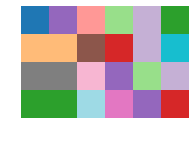

In [52]:
lbl_msk.show(alpha=1)

In [54]:
lbl_msk.data

tensor([[[  0,  90,  83,  59, 103,  52],
         [ 41,  39, 119,  70, 108, 211],
         [164, 164, 153, 100,  60, 103],
         [ 45,  45, 225, 138,  92,  76]]])

In [34]:
with open(p_classes, 'r') as classfile:
    reader = csv.reader(classfile)
    n = 0
    for line in reader:
        if n>0:
            row = (n-1)//6
            col = (n-1)%6
            val = values[0][row][line]
            print(val)
            ref = line[0]
            labels_d[val] = ref
        n+=1
labels_d
    

IndexError: too many indices for tensor of dimension 0

## Data preparation

In [9]:
img_lst = p_img.ls()
img_lst[:5]
len(img_lst)

400

In [10]:
msk_lst = p_masks.ls()
msk_lst[:5]

[PosixPath('data/Seg_Drone/semantic_drone_dataset/training_set/gt/semantic/label_images/043.png'),
 PosixPath('data/Seg_Drone/semantic_drone_dataset/training_set/gt/semantic/label_images/157.png'),
 PosixPath('data/Seg_Drone/semantic_drone_dataset/training_set/gt/semantic/label_images/344.png'),
 PosixPath('data/Seg_Drone/semantic_drone_dataset/training_set/gt/semantic/label_images/454.png'),
 PosixPath('data/Seg_Drone/semantic_drone_dataset/training_set/gt/semantic/label_images/488.png')]

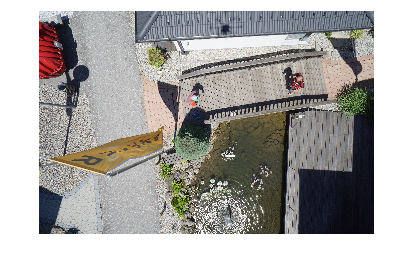

In [11]:
img_f = img_lst[50]      
img = open_image(img_f)
img.show(figsize=(6,6))

In [12]:
get_y_fn = lambda x: p_masks/f'{x.stem}.png'

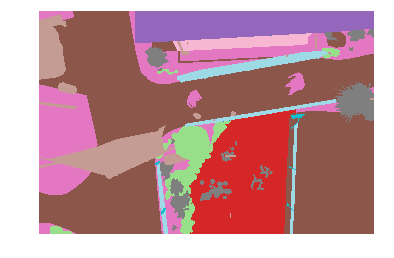

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(6,6), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size

array([4000, 6000])

In [18]:
mask.data

tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ..., 90, 90, 90],
         [ 0,  0,  0,  ..., 90, 90, 90],
         [ 0,  0,  0,  ..., 90, 90, 90]]])

In [24]:
mask.data.view((3,-1))

tensor([[ 0,  0,  0,  ..., 90, 90, 90],
        [90, 90, 90,  ..., 52, 52, 52],
        [52, 52, 52,  ..., 90, 90, 90]])

In [26]:
mask.data.view((3,-1)).permute(1,0)

tensor([[ 0, 90, 52],
        [ 0, 90, 52],
        [ 0, 90, 52],
        ...,
        [90, 52, 90],
        [90, 52, 90],
        [90, 52, 90]])

In [51]:
m = torch.zeros((4,9))
m

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [52]:
for i in range(m.shape[-2]):
    for j in range(m.shape[-1]):
        m[i][j]=(j+(i*9))//3
m

tensor([[ 0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.],
        [ 3.,  3.,  3.,  4.,  4.,  4.,  5.,  5.,  5.],
        [ 6.,  6.,  6.,  7.,  7.,  7.,  8.,  8.,  8.],
        [ 9.,  9.,  9., 10., 10., 10., 11., 11., 11.]])

In [57]:
m.data.view((3,-1))


tensor([[ 0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.],
        [ 4.,  4.,  4.,  5.,  5.,  5.,  6.,  6.,  6.,  7.,  7.,  7.],
        [ 8.,  8.,  8.,  9.,  9.,  9., 10., 10., 10., 11., 11., 11.]])

In [63]:
m.data.view((3,-1)).permute(1,0)

tensor([[ 0.,  4.,  8.],
        [ 0.,  4.,  8.],
        [ 0.,  4.,  8.],
        [ 1.,  5.,  9.],
        [ 1.,  5.,  9.],
        [ 1.,  5.,  9.],
        [ 2.,  6., 10.],
        [ 2.,  6., 10.],
        [ 2.,  6., 10.],
        [ 3.,  7., 11.],
        [ 3.,  7., 11.],
        [ 3.,  7., 11.]])

In [66]:
torch.sum(m.data.view((3,-1)).permute(1,0)== tensor([1,5,9]))

RuntimeError: Expected object of scalar type Float but got scalar type Long for argument #2 'other'

## Dataset

In [11]:
src = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else: bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [15]:
train_l = img_lst[:300]
valid_l = img_lst[:-1]

[PosixPath('data/Seg_Drone/semantic_drone_dataset/training_set/images/145.jpg'),
 PosixPath('data/Seg_Drone/semantic_drone_dataset/training_set/images/587.jpg'),
 PosixPath('data/Seg_Drone/semantic_drone_dataset/training_set/images/232.jpg'),
 PosixPath('data/Seg_Drone/semantic_drone_dataset/training_set/images/345.jpg'),
 PosixPath('data/Seg_Drone/semantic_drone_dataset/training_set/images/347.jpg')]

In [17]:
#DATABLOCK
src = (SegmentationItemList.from_folder(p_img)
      .split_by_list(train_l, valid_l)
      .label_from_func(get_y_fn))

AttributeError: 'list' object has no attribute 'ignore_empty'